# scRNAseq 的谱聚类

In [2]:
library(dplyr)
library(Seurat)
library(kernlab)
library(CrossClustering)
library(mclust)

In [3]:
# load benchmark dataset: zhengmix8eq
dat0 = readRDS(file = "~/Downloads/scrna2019-master/real_benchmarking/data/Zhengmix8eq/expr.rds")

In [5]:
# 利用表面marker划分出的细胞类别，作为‘金标准’
ID = dat0$phenoid
unique(ID) ## 共有八类

[1] "b.cells"         "naive.cytotoxic" "cd14.monocytes"  "regulatory.t"   
[5] "cd4.t.helper"    "cd56.nk"         "memory.t"        "naive.t"

In [6]:
counts = assay(dat0,"counts")
dim(counts) ## 1500个基因，3994个单细胞
counts[1:5,1:6]

[1] 1500 3994

,b.cells1147,b.cells6276,b.cells6144,b.cells6285,b.cells8679,b.cells6455
ENSG00000251562,29,25,34,44,42,40
ENSG00000167526,24,16,31,11,15,21
ENSG00000140988,15,21,18,11,13,12
ENSG00000147403,16,9,19,4,15,11
ENSG00000142541,15,15,29,11,15,18


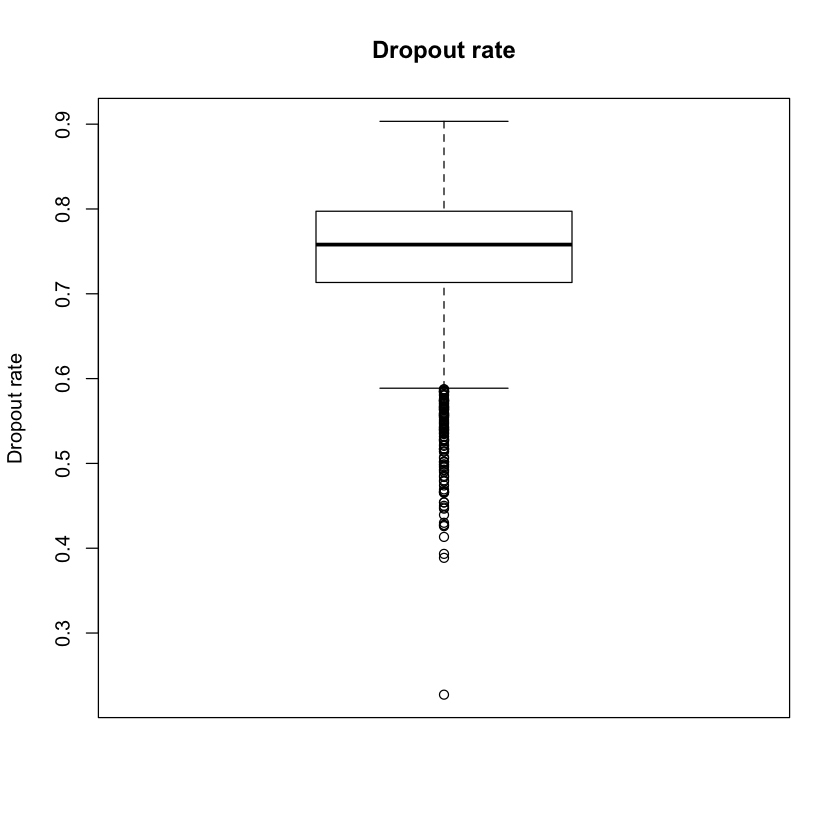

In [10]:
## dropout rate
boxplot(colSums(counts == 0)/nrow(counts),main = "Dropout rate",ylab = "Dropout rate")

## 1. Prepare data

In [12]:
# 1. Create Seurate object
dat = CreateSeuratObject(counts = assay(dat0,"counts"), project = "zhengmix8eq")

In [13]:
# 2. Normalization
dat <- NormalizeData(dat, normalization.method = "LogNormalize", scale.factor = 10000)

In [14]:
# 3. Find most variable genes
dat <- FindVariableFeatures(dat, selection.method = "vst", nfeatures = 1000)

In [18]:
# 4. Scale data
feat <- dat@assays$RNA@var.features
dat <- ScaleData(dat, features = feat)

Centering and scaling data matrix



## 2. Run PCA

In [21]:
dat <- RunPCA(dat, features = VariableFeatures(object = dat),verbose = F)

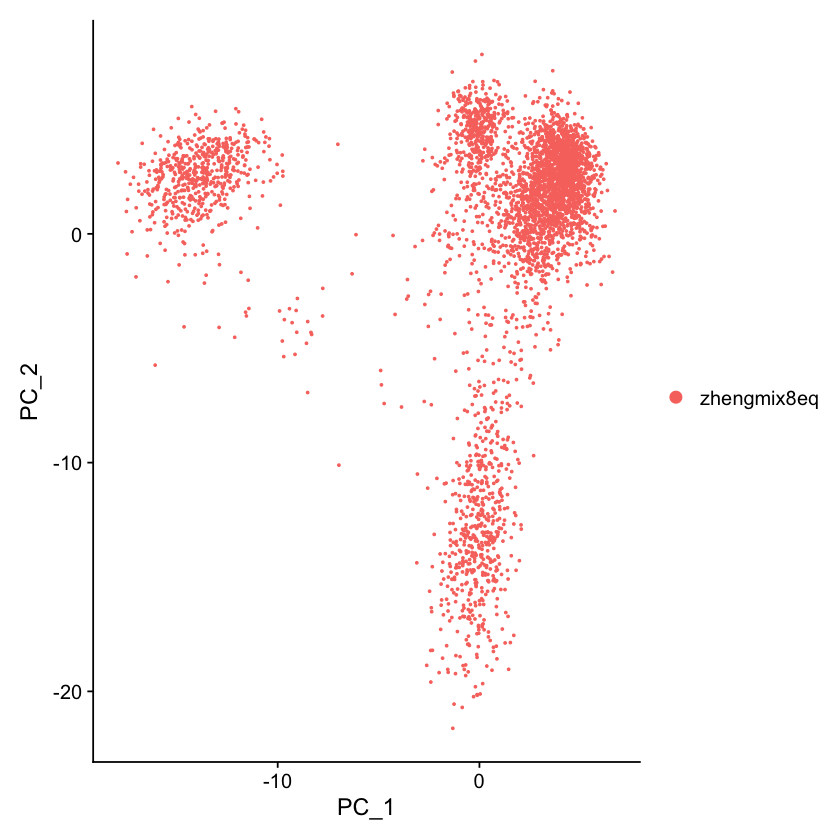

In [22]:
DimPlot(dat, reduction = "pca")

## 3. Spectral clustering

In [23]:
# 3.1 Find nearest neighbors
dat <- FindNeighbors(dat, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



In [24]:
# 3.2 spectral clustering 
dat <- FindClusters(dat, resolution = 0.6)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3994
Number of edges: 142633

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8660
Number of communities: 8
Elapsed time: 0 seconds


In [25]:
# look at the results
table(Idents(dat),ID)

   ID
    b.cells cd14.monocytes cd4.t.helper cd56.nk memory.t naive.cytotoxic
  0       0              6          174       5      460               4
  1       0              0          213       1       16               7
  2       0              1            2     592        0               0
  3       0            559            0       0        0               0
  4     467              2            0       1        0               1
  5       0              0           10       1       24             386
  6       0             32            1       0        0               0
  7      32              0            0       0        0               0
   ID
    naive.t regulatory.t
  0       9          342
  1     472          154
  2       1            0
  3       0            0
  4       1            0
  5      16            2
  6       0            0
  7       0            0

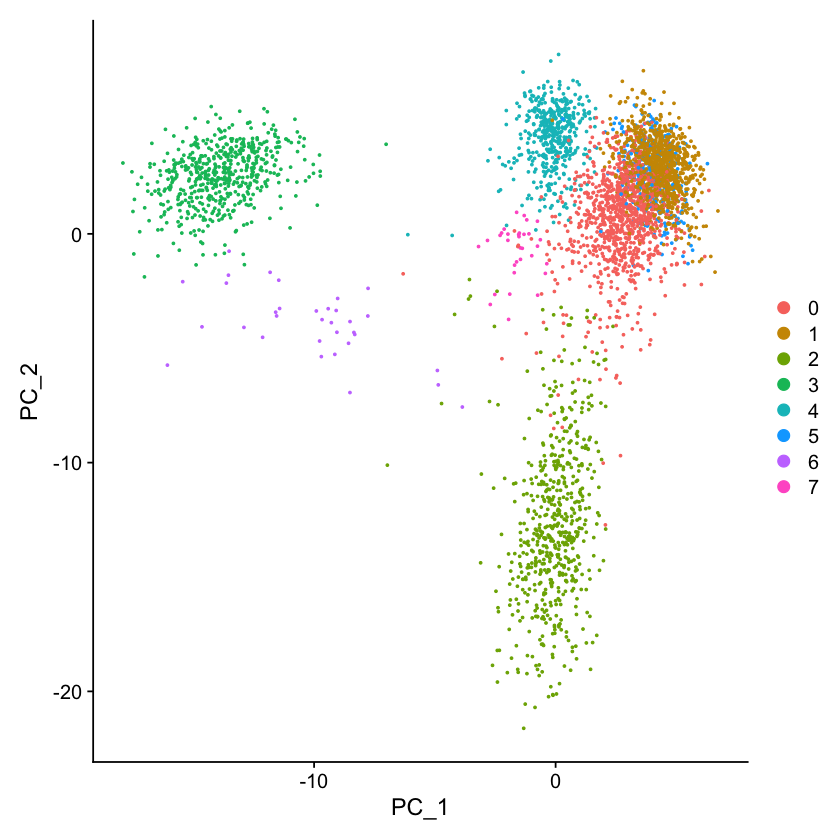

In [28]:
DimPlot(dat, reduction = "pca")

In [26]:
# calculate Adjusted Rand Index
adjustedRandIndex(Idents(dat),ID)

[1] 0.638355

## 4. Kmeans

In [27]:
# We can also try Kmeans 
km_cluster = kmeans(dat@reductions$pca@cell.embeddings[,1:5],8)
table(km_cluster$cluster,ID)
adjustedRandIndex(km_cluster$cluster,ID)

   ID
    b.cells cd14.monocytes cd4.t.helper cd56.nk memory.t naive.cytotoxic
  1       0              0            0     334        0               0
  2     471              2            0       1        0               1
  3       0              0          222       3      213             391
  4       0              1            1     258        0               0
  5       0            430            0       0        0               0
  6      28             29            3       0        5               0
  7       0            133            0       0        0               0
  8       0              5          174       4      282               6
   ID
    naive.t regulatory.t
  1       0            0
  2       1            0
  3     453          158
  4       0            0
  5       0            0
  6       2            5
  7       0            0
  8      43          335

[1] 0.3803109

Accuracy by Kmeans is much lower than that by Spectral Clustering.